In [1]:
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib

from matplotlib import pyplot as plt
import cv2
import supervision as sv
import os




/home/lorenzo/miniconda3/envs/tcc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

Device: cuda:0


In [4]:

def show_output(result_dict,axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))

def get_second_largest_area(result_dict):

    print(result_dict)
    return

    sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
    return sorted_result[1]



def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [2]:
def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = pred.size
    return correct / total

def intersection_over_union(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / union

def dice_coefficient(pred, target):
    intersection = (pred & target).sum()
    return 2 * intersection / (pred.sum() + target.sum())


def calculate_metrics(pred_list, target_list):
    pixel_acc = []
    iou = []
    dice = []
    for pred, target in zip(pred_list, target_list):
        pixel_acc.append(pixel_accuracy(pred, target))
        iou.append(intersection_over_union(pred, target))
        dice.append(dice_coefficient(pred, target))
    #return global metrics
    return np.mean(pixel_acc), np.mean(iou), np.mean(dice)



## SAM


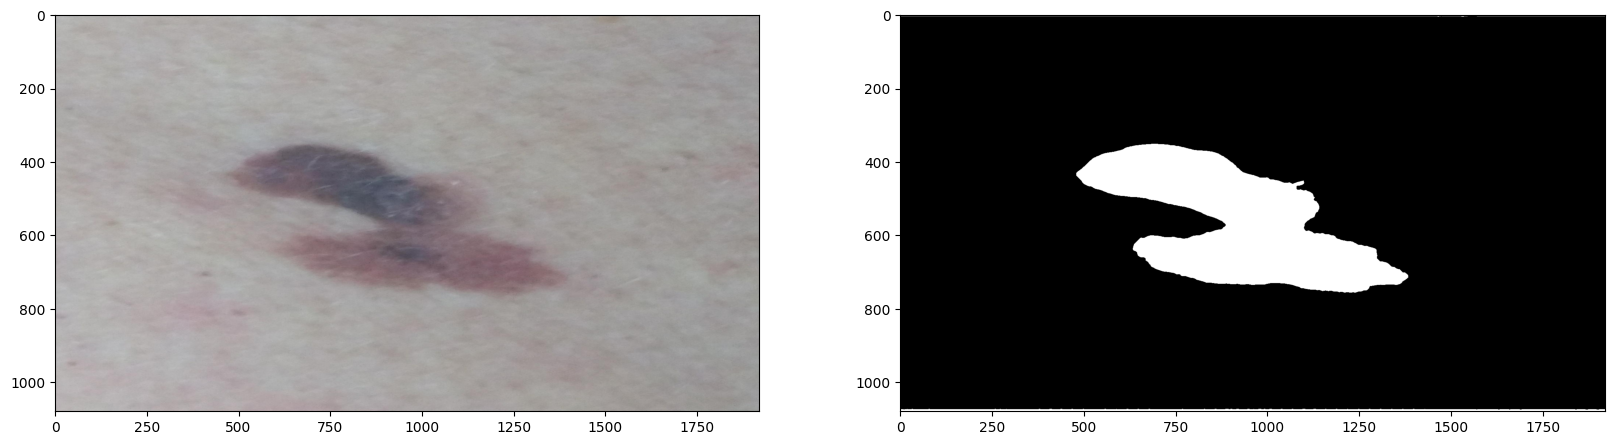

In [ ]:
mask_folder = './pad/train/mask/melanoma/'
real_images_folder = './pad/train/data/melanoma/'
result_folder = './result_sam/' 
#get the first image from mask folder, then get the corresponding image from real_images_folder, then generate the mask and save the image with the mask on at result_folder
image_name = os.listdir(real_images_folder)[6]
print(image_name)
def get_most_probable_area(result_dict, shape):
    #sort the result dict by area
    sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
    # return the one that has the largest area and does not touch the edges of the image
    # for val in sorted_result:
    #     bbox = val['bbox']
        

    #     if bbox[0] > 0 and bbox[1] > 0 and bbox[2] < shape[1] -50 and bbox[3] < shape[0] -50: 
    #         print(bbox)
    #         print(shape)
    #         return val
        
    return sorted_result[0]


# Read the image from the path
image = cv2.imread(real_images_folder + image_name)
#if image size is greater than 1920 1080, resize it
if image.shape[0] > 1920 or image.shape[1] > 1080:
    image = cv2.resize(image, (1920, 1080))
    
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate segmentation mask
output_mask = mask_generator.generate(image)

#get second largest area
mask = get_most_probable_area(output_mask, image.shape)

mask = mask['segmentation']
mask = np.logical_not(mask)
mask_img = mask.astype(np.uint8)
#invert the mask
mask_img = cv2.resize(mask_img, (image.shape[1], image.shape[0]))
mask_img = mask_img * 255
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2RGB)

#plot image and mask_img on side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image_rgb)
ax[1].imshow(mask_img)
plt.show()



In [10]:
gd_mask = cv2.imread(mask_folder + image_name.replace('.jpg', '_segmentation.png'))
gd_mask = cv2.cvtColor(gd_mask, cv2.COLOR_BGR2GRAY)
gd_mask = cv2.resize(gd_mask, (mask.shape[1], mask.shape[0]))
gd_mask = gd_mask > 0
gd_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [11]:
#apply metrics 
pixel_acc = pixel_accuracy(mask, gd_mask)
iou = intersection_over_union(mask, gd_mask)
dice = dice_coefficient(mask, gd_mask)

print(f"Pixel accuracy: {pixel_acc}")
print(f"Intersection over union: {iou}")
print(f"Dice coefficient: {dice}")

Pixel accuracy: 0.9801605902777778
Intersection over union: 0.811741502077575
Dice coefficient: 0.8960897579999444


In [12]:
original_dir = 'pad/train/data'

In [34]:
def get_segmentation_mask_from_image(img, shape=(1920, 1080)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape[0] > 1080 or img.shape[1] > 1080:
        img = cv2.resize(img, (1080, 1080))
    masks = img > 0
    return masks
    
#calculate metrics 
pred_list = []
target_list = []
original_masks_folder = 'pad/train/mask/melanoma/'
sam_masks_dir = 'sam_masks/melanoma'

for image_name in os.listdir(original_masks_folder):
    # Read the image from the path
    original_mask = cv2.imread(os.path.join(original_masks_folder,image_name.replace('.jpg', '_segmentation.png')))
    original_mask = get_segmentation_mask_from_image(original_mask, original_mask.shape)
    
    sam_mask = cv2.imread(os.path.join(sam_masks_dir, image_name.replace('.jpg', '_segmentation.png')))
    sam_mask = get_segmentation_mask_from_image(sam_mask, original_mask.shape)

    pred_list.append(sam_mask)
    target_list.append(original_mask)

original_masks_folder = 'pad/test/mask/melanoma/'

for image_name in os.listdir(original_masks_folder):
    # Read the image from the path
    original_mask = cv2.imread(os.path.join(original_masks_folder,image_name.replace('.jpg', '_segmentation.png')))
    original_mask = get_segmentation_mask_from_image(original_mask, original_mask.shape)
    
    sam_mask = cv2.imread(os.path.join(sam_masks_dir, image_name.replace('.jpg', '_segmentation.png')))
    sam_mask = get_segmentation_mask_from_image(sam_mask, original_mask.shape)

    pred_list.append(sam_mask)
    target_list.append(original_mask)



pixel_acc, iou, dice = calculate_metrics(pred_list, target_list)
print(f"Pixel accuracy: {pixel_acc}")
print(f"Intersection over union: {iou}")
print(f"Dice coefficient: {dice}")

    

Pixel accuracy: 0.8679274434052251
Intersection over union: 0.7213227773720341
Dice coefficient: 0.8055660494168672


In [8]:
import os
import cv2
import numpy as np

pread_list = []
target_list = []

def get_segmentation_mask_from_image(img, shape=(1920, 1080)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape[0] > 1080 or img.shape[1] > 1080:
        img = cv2.resize(img, (1080, 1080))
    masks = img > 0
    return masks

# Base directories
base_masks_folder = 'pad/train/mask/'
sam_masks_dir = 'sam_masks/'

# Get list of all subdirectories in the base directory
subdirs = [d for d in os.listdir(base_masks_folder) if os.path.isdir(os.path.join(base_masks_folder, d))]

pixel_acc_ = []
iou_ = []
dice_ = []
sum_ = 0
# Loop over all subdirectories
for subdir in subdirs:
    # Initialize lists for predictions and targets
    pred_list = []
    target_list = []

    # Update mask folders for current subdir
    original_masks_folder = os.path.join(base_masks_folder, subdir)
    current_sam_masks_dir = os.path.join(sam_masks_dir, subdir)

    for image_name in os.listdir(original_masks_folder):
        # Read the image from the path
        sam_mask = cv2.imread(os.path.join(current_sam_masks_dir, image_name.replace('.jpg', '_segmentation.png')))
        original_mask = cv2.imread(os.path.join(original_masks_folder, image_name.replace('.jpg', '_segmentation.png')))
     
        original_mask = get_segmentation_mask_from_image(original_mask)
        sam_mask = get_segmentation_mask_from_image(sam_mask)

        pred_list.append(sam_mask)
        target_list.append(original_mask)
    
    sum_ = sum_ + len(pred_list)
    pixel_acc, iou, dice = calculate_metrics(pred_list, target_list)
    pixel_acc_.append(pixel_acc)
    iou_.append(iou)
    dice_.append(dice)
    # Here you can calculate and print/save the metrics for the current subdir using pred_list and target_list

In [9]:

pixel_total_acc = np.mean(pixel_acc_)
pixel_total_iou = np.mean(iou_)
pixel_total_dice = np.mean(dice_)
print(sum_)
print(f"Pixel accuracy: {pixel_total_acc}")
print(f"Intersection over union: {pixel_total_iou}")
print(f"Dice coefficient: {pixel_total_dice}")


741
Pixel accuracy: 0.8722577169473857
Intersection over union: 0.3211104772032398
Dice coefficient: 0.3795098915218408


TypeError: object of type 'numpy.float64' has no len()

## SKIN SAM


In [6]:
import cv2
import numpy as np
import os 
import PIL
from matplotlib import pyplot as plt


!pip install transformers
# Load model directly
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("mask-generation", model="ahishamm/skinsam")


In [7]:
modelmask_folder = './pad/train/mask/melanoma/'
real_images_folder = './pad/train/data/melanoma/'
result_folder = './result_sam/' 
#get the first image from mask folder, then get the corresponding image from real_images_folder, then generate the mask and save the image with the mask on at result_folder
image_name = os.listdir(real_images_folder)[3]

# Read the image from the path
# image = cv2.imread(real_images_folder + image_name)
image_path = real_images_folder + image_name
image = PIL.Image.open(image_path)
#if image size is greater than 1920 1080, resize it
if image.size[0] > 1920 or image.size[1] > 1080:
    image = image.resize((1920, 1080))
    
# Generate segmentation mask
# mask = pipe(image)
mask = pipe(image)

In [9]:
def apply_mask(image, mask, color=None):
    # Convert the mask to a 3 channel image
    if color is None:
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    else:
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask>0] = color

    # Overlay the mask and image
    overlay_image = cv2.addWeighted(image, 0.7, mask_rgb, 0.3, 0)

    return overlay_image


In [ ]:

#get the largest mask area on masks 
def get_largest_area(masks): 
    largest = None
    for mask in masks:
        mask = mask > 0
        if largest is None:
            largest = mask
        else:
            if mask.sum() > largest.sum():
                largest = mask
    return largest


In [14]:

skin_sam_masks_dir = './skin_sam_masks/'
os.makedirs(skin_sam_masks_dir, exist_ok=True)

for image_name in os.listdir(real_images_folder):
    if (image_name[:-4] + "_segmentation.png")  in os.listdir(skin_sam_masks_dir):
        continue
    # Read the image from the path
    image_path = real_images_folder + image_name
    image = PIL.Image.open(image_path)
    if image.size[0] > 1920 or image.size[1] > 1080:
        image = image.resize((1920, 1080))

    # Generate segmentation mask
    mask = pipe(image)
    # mask = np.array(mask['masks'])[1]
    mask = get_largest_area(mask['masks'])
    mask = mask > 0
    mask = mask.astype(np.uint8)
    mask = cv2.resize(mask, (image.size[0], image.size[1]))
    mask = mask * 255
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    #save the mask
    cv2.imwrite(skin_sam_masks_dir + image_name.replace('.jpg', '_segmentation.png'), mask)

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

def apply_masks_to_image(image_path, masks):
    # Load the image
    image = cv2.imread(image_path)
    #write original image
    cv2.imwrite(f'original_image.jpg', image)

    for i, mask in enumerate(masks):
        # Ensure the mask is a boolean array
        mask = np.array(mask, dtype=bool)

        # Apply the mask to the image
        masked_image = np.zeros_like(image)
        masked_image[mask] = image[mask]

        # Save the image
        cv2.imwrite(f'masked_image_{i}.jpg', masked_image)
apply_masks_to_image(image_path, masks)